# Amazon Personalize Kickstart - Data exploration
The goal of the Amazon Personalize kickstart, is to provide you a kickstart for your personalization journey when building a recommendation engine based on Amazon Personalize. It will serve you as a reference implementation you can both learn the concepts and integration aspects of Amazon Personalize. 

## What do we want to achieve?
We want to build a recommendation engine covering all features of Amazon Personalize. The dataset we will use is the publicly available MovieLens dataset. 

> GroupLens Research has collected and made available rating data sets from the MovieLens web site (https://movielens.org). The data sets were collected over various periods of time, depending on the size of the set. Before using these data sets, please review their README files for the usage licenses and other details.

Source: https://grouplens.org/datasets/movielens/

The MovieLens dataset contains 25 million movie ratings and a rich set of movie metadata. We will use this data to provide an initial version of our recommendation engine based on historical data. In the next section it is all about analyizing the data to get a better understanding of data quality as well our domain. Next we have to prepare the data and transform it into a format Amazon Personalize can process and understand. We will cover things like what kind of data is required for Amazon Personalize and how to define data schemas. 

Before you just import your historical data, it is recommended to gather knowledge. Both on your data and on your business domain. 
Every recommendation engine project is kind of unique if we look at the data we have to process and the way the business works. In a very first step during a proof-of-concept phase, it is all about finding answers on:
 * What data can we use?
 * What data do we need?
 * Is our data quality sufficient?
 * How do we access the required data?
 * How do we identify users, interaction or items we want to recommend?
 
Collaborative sessions with subject matter experts help us in building an optimal solution along the given circumstances. Well in our kickstart project, unfortunately there are no subject matter experts available right now. But let us start with what we have ☺️ Data! 

Those analyses are both inspired from my personal experiences as well as a lot of cool stuff of the open source community like the following:
* [Analysis on the Movie Lens dataset using pandas](https://notebook.community/harishkrao/DSE200x/Mini%20Project/Analysis%20on%20the%20Movie%20Lens%20dataset)
* [Amazon Personalize immersion day](https://personalization-immersionday.workshop.aws/en/)
* [Analysis of MovieLens dataset (Beginner'sAnalysis)](https://www.kaggle.com/jneupane12/analysis-of-movielens-dataset-beginner-sanalysis)
* [Data Analysis using the MovieLens dataset with pandas](https://www.youtube.com/watch?v=8kElv1sticI)
* [Comprehensive Data Visualization with Matplotlib](https://towardsdatascience.com/comprehensive-data-explorations-with-matplotlib-a388be12a355)

My goal is to not reinvent the wheel at all. But bring all relevant analyses in one place that help us to judge if our data fit to be used for a recommendation engine based on Amazon Personalize. I will cite the source of each analysis in the following parts. If you don't find any cross reference, the analysis bases on my own experiences which you can of course adapt or reuse.

Before you start with your analysis. It is recommended to define some key questions you would like to answer using data analysis. By analyzing the Movielens datasets we want to answer some very specific questions about our movie business:
* [What are the top 10 most rated movies?](#What-are-the-top-10-most-rated-movies?)
* [Are ratings in general more positive or negative?](#Are-ratings-in-general-more-positive-or-negative?)
* [Is there a correlation between genres?](#Is-there-a-correlation-between-genres?)
* [Are there some genres more dominant compared to others?](#Are-there-some-genres-more-dominant-compared-to-others?)
* [What is the distribution of the release years of our movies?](#What-is-the-distribution-of-the-release-years-of-our-movies?)
* [What is the distribution of genres per release year?](#What-is-the-distribution-of-genres-per-release-year?)
* [How many movies does a user rate?](#How-many-movies-does-a-user-rate?)

Finally we want to come to some conclusions with regards to Amazon Personalize.
* [Can we transform our data to a schema Amazon Personalize is able to process?](#Can-we-transform-our-data-to-a-schema-Amazon-Personalize-is-able-to-process?)
* [Do we have enough data to train a model using Amazon Personalize?](#Do-we-have-enough-data-to-train-a-model-using-Amazon-Personalize)

So let us get started and dive into our dataset. 🕵️

## General setup
### Imports and declarations
First let us import some required python libraries for the following steps.

In [1]:
from datetime import datetime
import pandas as pd

data_dir = "movielens"
dataset_dir = data_dir + "/ml-latest-small/"
!mkdir $data_dir

mkdir: cannot create directory ‘movielens’: File exists


### Download the MovieLens dataset
Our very first step is to download the sample dataset. We will save the data directly onto the Amazon EBS instance attached to instance running this Jupyter notebook for our initial analysis. After you downloaded the files, you will see them in your notebook file browser on the left side. 

In [59]:
!cd $data_dir && wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!cd $data_dir && unzip ml-latest-small.zip

--2021-10-07 12:26:43--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  1.22MB/s    in 0.8s    

2021-10-07 12:26:44 (1.22 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


### README
The dataset contains a lot of interesting csv files. Like `tags.csv`, `links.csv` or `ratings.csv`. We do not have a subject matter export to explain us the world of MovieLens. But someone wrote a `README.txt` to dive deeper in what treasure we digged out. 🌟

In [18]:
cat $dataset_dir/README.txt

Summary

This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in the files `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`. More details about the contents and use of all these files follows.

This is a *development* dataset. As such, it may change over time and is not an appropriate dataset for shared research results. See available *benchmark* datasets if that is your intent.

This and other GroupLens data sets are publicly available for down

---
Awesome 🎉. This gives us a good starting point about the kind of data we got and how they relate to each other. Now let us take a closer look, what requirements Amazon Personalize has on the data.

For Amazon Personalize the data you put in are categorized in so called datasets like
* your user [interactions](https://docs.aws.amazon.com/personalize/latest/dg/interactions-datasets.html) like watched videos, read articles and so on,
* Metadata of the things you want to recommend – called [items](https://docs.aws.amazon.com/personalize/latest/dg/items-datasets.html). 
* And metadata about your [users](https://docs.aws.amazon.com/personalize/latest/dg/users-datasets.html) like demographic data for example

Each of those datasets is described using a [Avro formatted schema](https://docs.aws.amazon.com/personalize/latest/dg/how-it-works-dataset-schema.html#dataset-requirements) definition. The schema definition requires some attributes that are mandatory to provide in our datasets. It further defines some reserved keywords we are not allowed to use. The [Amazon Personalize developer guide](https://docs.aws.amazon.com/personalize/latest/dg/how-it-works-dataset-schema.html#dataset-requirements) provides a good overview about the schema requirements we have to fullfill.

Amazon Personalize does not force you to provide all three datasets. The minimum requirement is to provide an interaction dataset. If you have the chance to provide an explicit items or users dataset it is likely to improve your recommendations the more context and metadata you can provide. 

Let's now have a look what data we can use and if we can judge about the data quality for our use case.

## Load the datasets
### 1. Ratings
Let us load our ratings into a panda dataframe and take a look at some sample rows using `.head()`. The `shape` property of the dataframe gives us some insights about the total number of columns and rows. `.describe()` generates descriptive statistics for each column. And finally `.info` prints information about our DataFrame including the index dtype and columns, non-null values and memory usage.

In [2]:
raw_ratings = pd.read_csv(dataset_dir + '/ratings.csv')
raw_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
raw_ratings.shape

(100836, 4)

In [4]:
raw_ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [5]:
raw_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


### 2. Movies
Let us load our movie metadata into a panda dataframe and take a look at some sample rows using `.head()`. The `shape` property of the dataframe gives us some insights about the total number of columns and rows. `.describe()` generates descriptive statistics for each column. And finally `.info` prints information about our DataFrame including the index dtype and columns, non-null values and memory usage.

In [6]:
raw_movies = pd.read_csv(dataset_dir + '/movies.csv')
raw_movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
raw_movies.shape

(9742, 3)

In [8]:
raw_movies.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


In [9]:
raw_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


### 2. Tags
Let us load the tagging metadata from our users into a panda dataframe and take a look at some sample rows using `.head()`. The `shape` property of the dataframe gives us some insights about the total number of columns and rows. `.describe()` generates descriptive statistics for each column. And finally `.info` prints information about our DataFrame including the index dtype and columns, non-null values and memory usage.

In [10]:
raw_tags = pd.read_csv(dataset_dir + '/tags.csv')
raw_tags.head(5)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [11]:
raw_tags.shape

(3683, 4)

In [12]:
raw_tags.describe()

,userId,movieId,timestamp
count,3683.000000,3683.000000,3.683000e+03
mean,431.149335,27252.013576,1.320032e+09
std,158.472553,43490.558803,1.721025e+08
min,2.000000,1.000000,1.137179e+09
25%,424.000000,1262.500000,1.137521e+09
50%,474.000000,4454.000000,1.269833e+09
75%,477.000000,39263.000000,1.498457e+09
max,610.000000,193565.000000,1.537099e+09


In [13]:
raw_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


### 3. Merged dataframes

In [14]:
movie_rating = pd.merge(raw_ratings, raw_movies, how="left", right_on="movieId", left_on="movieId")
movie_rating.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


### What did we learn about our data?
* In total we have 100836 movie ratings available
* Ratings range from 0.5 to 5.0 with a mean of 3.5 stars across all movies
* Ratings can be considered as positive (< 3.0) and positive (>= 3.0)
* There is a total number of 9741 movies available.
* Genres are denormalized into a pipe separated string
* Tags are denormalized. Each row represents a tag from a user for a given movie
* The title also contains the release year. We have to split those information to model them as atomic values.
* All `timestamp` columns are typed with `int64`

## Data Exploration
### What are the top 10 most rated movies?
We want to know better, what movies are top rated in our system. We use the merged dataframe of movies and ratings, group it by title and sort by the number of rows per movie to get the top 10 movies.

<AxesSubplot:title={'center':'Top 10 most rated movies'}, ylabel='Number of ratings'>

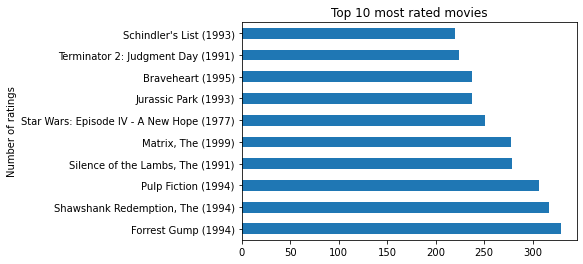

In [21]:
top_ten_movies = movie_rating.groupby("title").size().sort_values(ascending=False)[:10]
top_ten_movies.plot(kind="barh", x="rating", xlabel="Number of ratings", title='Top 10 most rated movies')

If we build our recommender system based on ratings, we have to check if we introduce some bias in our model. It could happen that top rated movies are recommended more often compared to less rated videos in the end. This is something to be discussed with subject matter experts to have clear expectations. So let us also take a look on the videos that have the least ratings. 

<AxesSubplot:title={'center':'Top 10 movies with least ratings'}, ylabel='Number of ratings'>

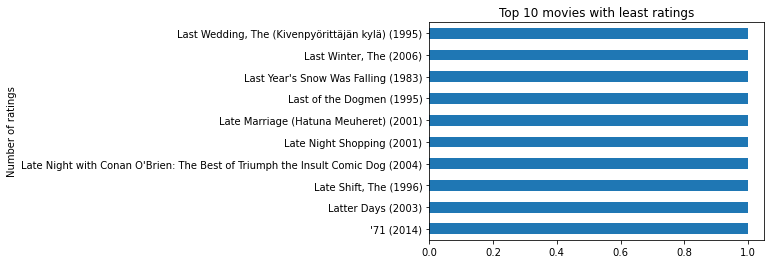

In [23]:
least_ten_movies = movie_rating.groupby("title").size().sort_values(ascending=True)[:10]
least_ten_movies.plot(kind="barh", x="rating", xlabel="Number of ratings", title='Top 10 movies with least ratings')

### How many movies does a user rate?
Ratings are one of the central interaction types we have right now. But how many interactions do we get then per user? Let us group the ratings by user and collect the number of ratings per user. Visualizing the data in a box chart gives us information about the distribution of ratings. 

<AxesSubplot:title={'center':'Ratings per user'}, ylabel='Ratings'>

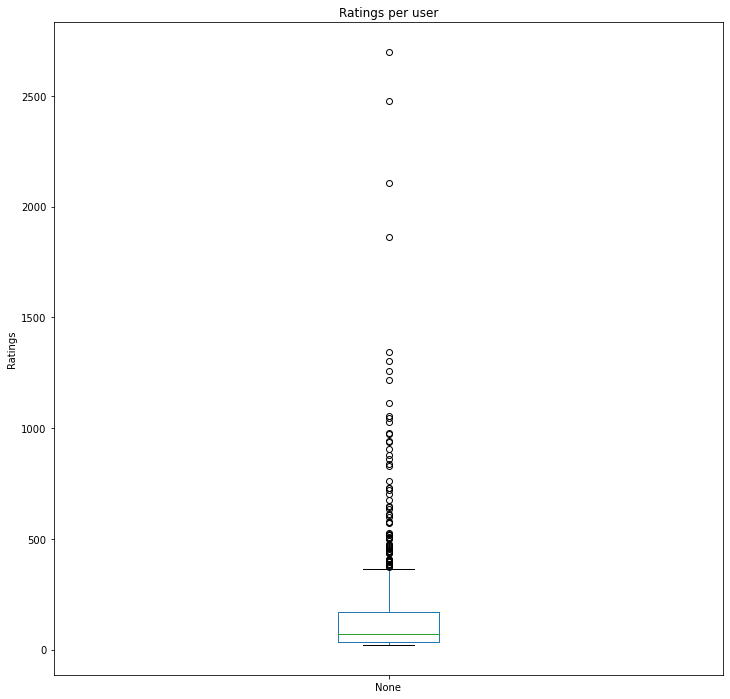

In [34]:
rated_movies_by_user = raw_ratings.groupby("userId").size().sort_values(ascending=False)
rated_movies_by_user.plot.box(figsize=(12,12), ylabel="Ratings", title='Ratings per user')

There are a lot outliner power users that rate a lot. While the median rating per user (green line) is something between 50 and 100. Let us also build a analyis that could be convienient to visualize the ratings of a given user.

<AxesSubplot:title={'center':'Ratings of user 130'}, xlabel='rating', ylabel='title'>

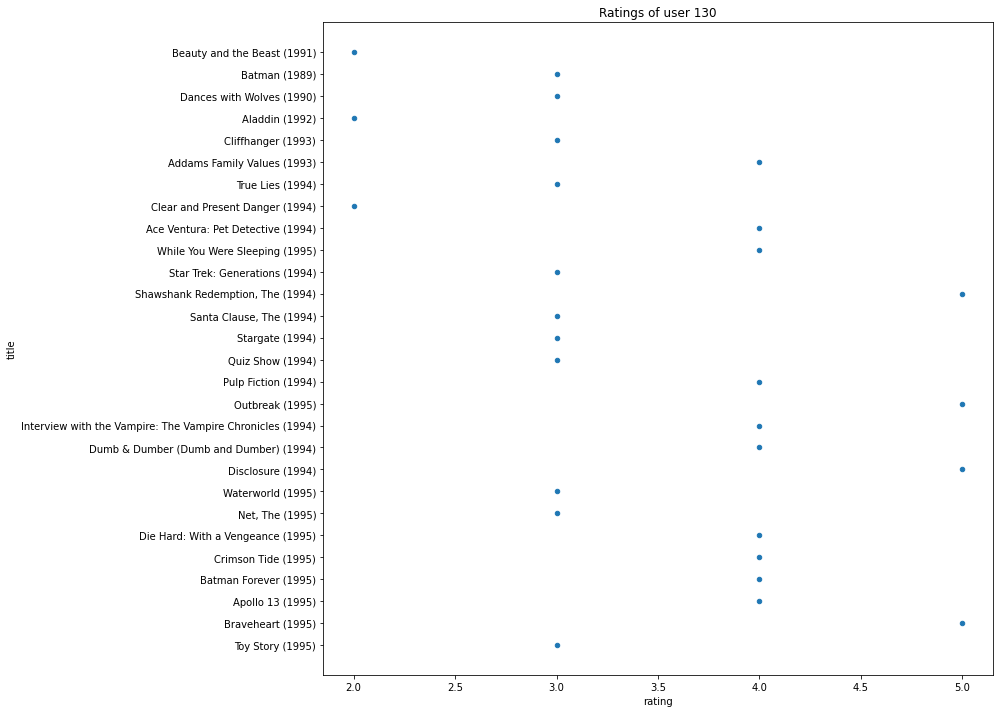

In [36]:
user_ratings = movie_rating[movie_rating['userId']==130]
user_ratings.plot.scatter(x='rating',y='title', figsize=(12,12), xlabel="Rating", ylabel="Movie", title='Ratings of user 130')

### Are ratings in general more positive or negative? 
We want to know more about the distribution of ratings. Our hypothesis is, that recommending low rated videos might not be a good user experience. On the otherside we might not be too aggressive as it can lead to biased recommendation by ignoring those low rated videos. Maybe there are users that are still interested in low rated videos because they fit their favorite genre. Who knows?

Let us in a first step visualize the distribution of all ratings. In a next step we will categorize ratings that lower than 3.0 as a negative rating. All other ratings will be categorized as a positive rating. 

<AxesSubplot:title={'center':'Number of ratings per value'}, ylabel='Rating value'>

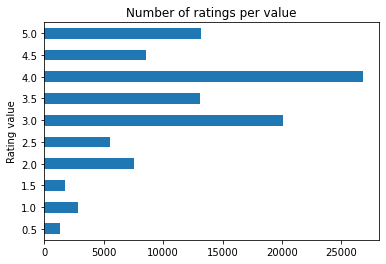

In [42]:
raw_ratings['rating'].value_counts().sort_index().plot(kind='barh', y="rating", ylabel="Rating value", title='Number of ratings per value')

In [40]:
rating_sentiment = raw_ratings.copy()
rating_sentiment["sentiment"] = rating_sentiment["rating"].map(lambda x: "positive" if x > 3.0 else "negative")
rating_sentiment.head()

,userId,movieId,rating,timestamp,sentiment
0,1,1,4.0,964982703,positive
1,1,3,4.0,964981247,positive
2,1,6,4.0,964982224,positive
3,1,47,5.0,964983815,positive
4,1,50,5.0,964982931,positive


<AxesSubplot:title={'center':'Rating sentiment'}>

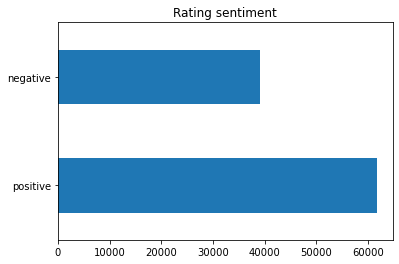

In [43]:
rating_sentiment['sentiment'].value_counts().plot(kind='barh', title='Rating sentiment')

The answer to this question: the majority of ratings are positive.

### What are the amount of ratings per day?

<AxesSubplot:title={'center':'Ratings per day'}, xlabel='Date', ylabel='Ratings'>

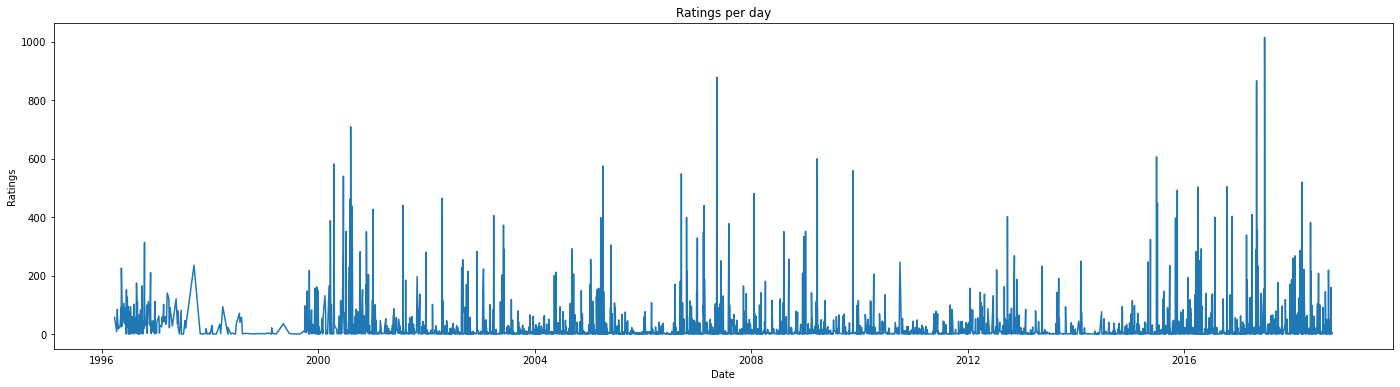

In [47]:
ratings_per_day = raw_ratings.copy()
ratings_per_day['date'] = pd.to_datetime(ratings_per_day['timestamp'], unit="s").dt.date
ratings_per_day = ratings_per_day.groupby("date").size()
ratings_per_day.plot(figsize=(24,6), x="date", xlabel="Date", ylabel="Ratings", title='Ratings per day')

### Is there a correlation between genres?
We want to check if we see some interesting correlations of genres that might give us some additional background information if multiple genres are applied. First we drop all columns we are not interested to evaluate like the `movieId` and the `title`. Next we split the `genres` column by the pipe character to get a list of genres. 
With this transformation in place we now apply a one-hot encoding to convert the list of genres in categorical variables. Based on this we can plot a correlation diagram.

In [50]:
genres = raw_movies.copy()
genres = genres.drop(columns=['movieId', 'title'])
genres['genres'] = genres['genres'].str.split('|')
genres_dummies = pd.get_dummies(pd.DataFrame(genres['genres'].tolist()).stack()).sum(level=0)
genres = pd.concat([genres, genres_dummies], axis=1).drop(columns=['genres'])
corr = genres.corr()
corr.style.background_gradient(cmap='coolwarm').set_properties(**{'font-size': '0pt'})

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
(no genres listed),1.000000,-0.028442,-0.022840,-0.015309,-0.016005,-0.046878,-0.022171,-0.012871,-0.053277,-0.017447,-0.005618,-0.019769,-0.007599,-0.011151,-0.014794,-0.026195,-0.019792,-0.029073,-0.011956,-0.007816
Action,-0.028442,1.000000,0.291949,0.029659,-0.049652,-0.148968,0.154471,-0.099463,-0.152964,0.059931,-0.031649,-0.035443,0.131864,-0.083331,-0.028515,-0.146670,0.233475,0.199042,0.076289,0.021600
Adventure,-0.022840,0.291949,1.000000,0.211472,0.273931,-0.055215,-0.085988,-0.075111,-0.156327,0.262511,-0.030140,-0.098423,0.143982,-0.005544,-0.048427,-0.072584,0.181797,-0.035942,0.010195,0.036136
Animation,-0.015309,0.029659,0.211472,1.000000,0.437376,0.029079,-0.069847,-0.050144,-0.160504,0.196895,-0.015555,-0.062464,0.080744,0.111804,-0.030477,-0.061882,0.064093,-0.107822,-0.036990,-0.024378
Children,-0.016005,-0.049652,0.273931,0.437376,1.000000,0.088701,-0.086442,-0.056859,-0.160742,0.234117,-0.025673,-0.083569,0.062011,0.137072,-0.036449,-0.070189,-0.011910,-0.127716,-0.048341,-0.016890
Comedy,-0.046878,-0.148968,-0.055215,0.029079,0.088701,1.000000,-0.075282,-0.131657,-0.283472,-0.005708,-0.070710,-0.133382,-0.056627,0.045466,-0.127209,0.153088,-0.132400,-0.286289,-0.095919,-0.039622
Crime,-0.022171,0.154471,-0.085988,-0.069847,-0.086442,-0.075282,1.000000,-0.073955,0.063005,-0.086254,0.137141,-0.063805,-0.020892,-0.056850,0.124138,-0.097444,-0.095166,0.265196,-0.059585,-0.022997
Documentary,-0.012871,-0.099463,-0.075111,-0.050144,-0.056859,-0.131657,-0.073955,1.000000,-0.173925,-0.060473,-0.020645,-0.069364,0.003381,-0.005664,-0.050168,-0.093597,-0.072736,-0.104346,-0.013378,-0.024915
Drama,-0.053277,-0.152964,-0.156327,-0.160504,-0.160742,-0.283472,0.063005,-0.173925,1.000000,-0.106337,0.024256,-0.187391,-0.063293,-0.038022,0.027635,0.122454,-0.158325,-0.008267,0.135067,-0.025060
Fantasy,-0.017447,0.059931,0.262511,0.196895,0.234117,-0.005708,-0.086254,-0.060473,-0.106337,1.000000,-0.023962,0.012336,0.102962,0.050524,0.014768,-0.000635,0.046094,-0.057807,-0.043959,-0.021441


The correlation analysis show, that there a no significant correlations visible in the sample dataset. Only the correlation between the genre of "Children" and "Animation" shows some hints. Would be interesting to apply this analysis with the whole Movielens dataset and not only the reduced sample.

### Are there some genres more dominant compared to others?
Based on the denormalized string of genres it is hard to judge about the distribution of single genres. Let's take a deeper look on the distribution of single genres accross all movies. We split the genres column by the pipe character to get a list of genres. We then next reindex the Dataframe to get all the unique genre identifier to visualize the total number of genres.

<AxesSubplot:title={'center':'Number of movies per genre'}>

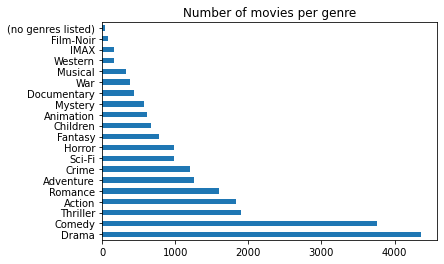

In [52]:
genres = raw_movies.copy()
genres['genres'] = genres['genres'].str.split('|')
genres['genres'].apply(lambda x: pd.Series([i for i in x])).stack().value_counts().plot(kind="barh", title='Number of movies per genre')

The genres "Drama" and "Comedy" are compared to all others kind of dominant. The number of unique genres is congruent to the list provided in the `README.txt` file.

### What is the distribution of the release years of our movies?

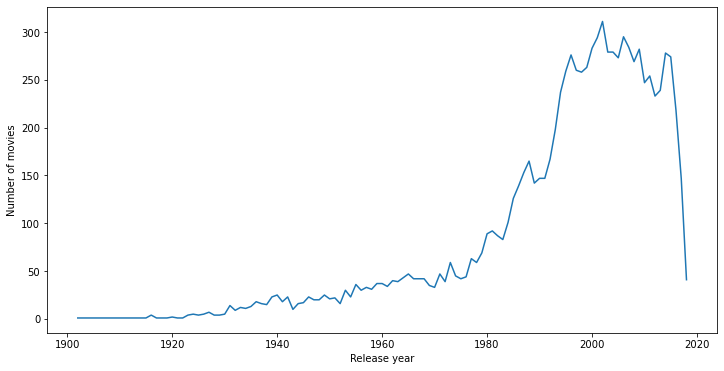

In [55]:
movies = raw_movies.copy()
movies['release_year'] = movies['title'].str.extract('\((\d{4})\)',expand = False)
movies = movies.dropna(axis=0)
movies['release_year'] = movies['release_year'].astype('int64')
movies['title'] = movies['title'].str.extract('(.*?)\s*\(', expand=False)

movie_year = pd.DataFrame(movies['title'].groupby(movies['release_year']).count())
movie_year.reset_index(inplace=True)
movie_year.plot(x="release_year", y="title", legend=False, xlabel="Release year", ylabel="Number of movies", figsize=(12, 6));

In [125]:
movie_year.describe()

,release_year,title
count,106.000000,106.000000
mean,1965.198113,91.783019
std,31.291691,102.227757
min,1902.000000,1.000000
25%,1939.250000,16.000000
50%,1965.500000,39.500000
75%,1991.750000,151.500000
max,2018.000000,311.000000


Movies range from release dates from 1902 till 2018. Since round about 1980 the amount of release movies seems to be increasing more strongly. Ther is an interesting drop of releases round about in the year of 2012. In 2018 nearly the same amount of movies were release like in the end of the 70s.

If there were subject matter experts in place, those analysis might result in some very interesting question to better understand the driver of both the increase in the 80s but also the drop after 2010.

### What is the distribution of genres per release year?
For this analysis we use a combination of the previous one with the one to split genres into single categories. First we extract the release year and convert it to an integer value. Then we also split the concatenated genres into a list of genres and create categorized values out of each individual genre. We then drop all columns that are not needed like the origin concatenated genre column or the title or movieId. 

Similar to the previous analysis we now group the dataframe by release year and sum all genres up. In the end we visualize each genre grouped by year in a dedicated chart.

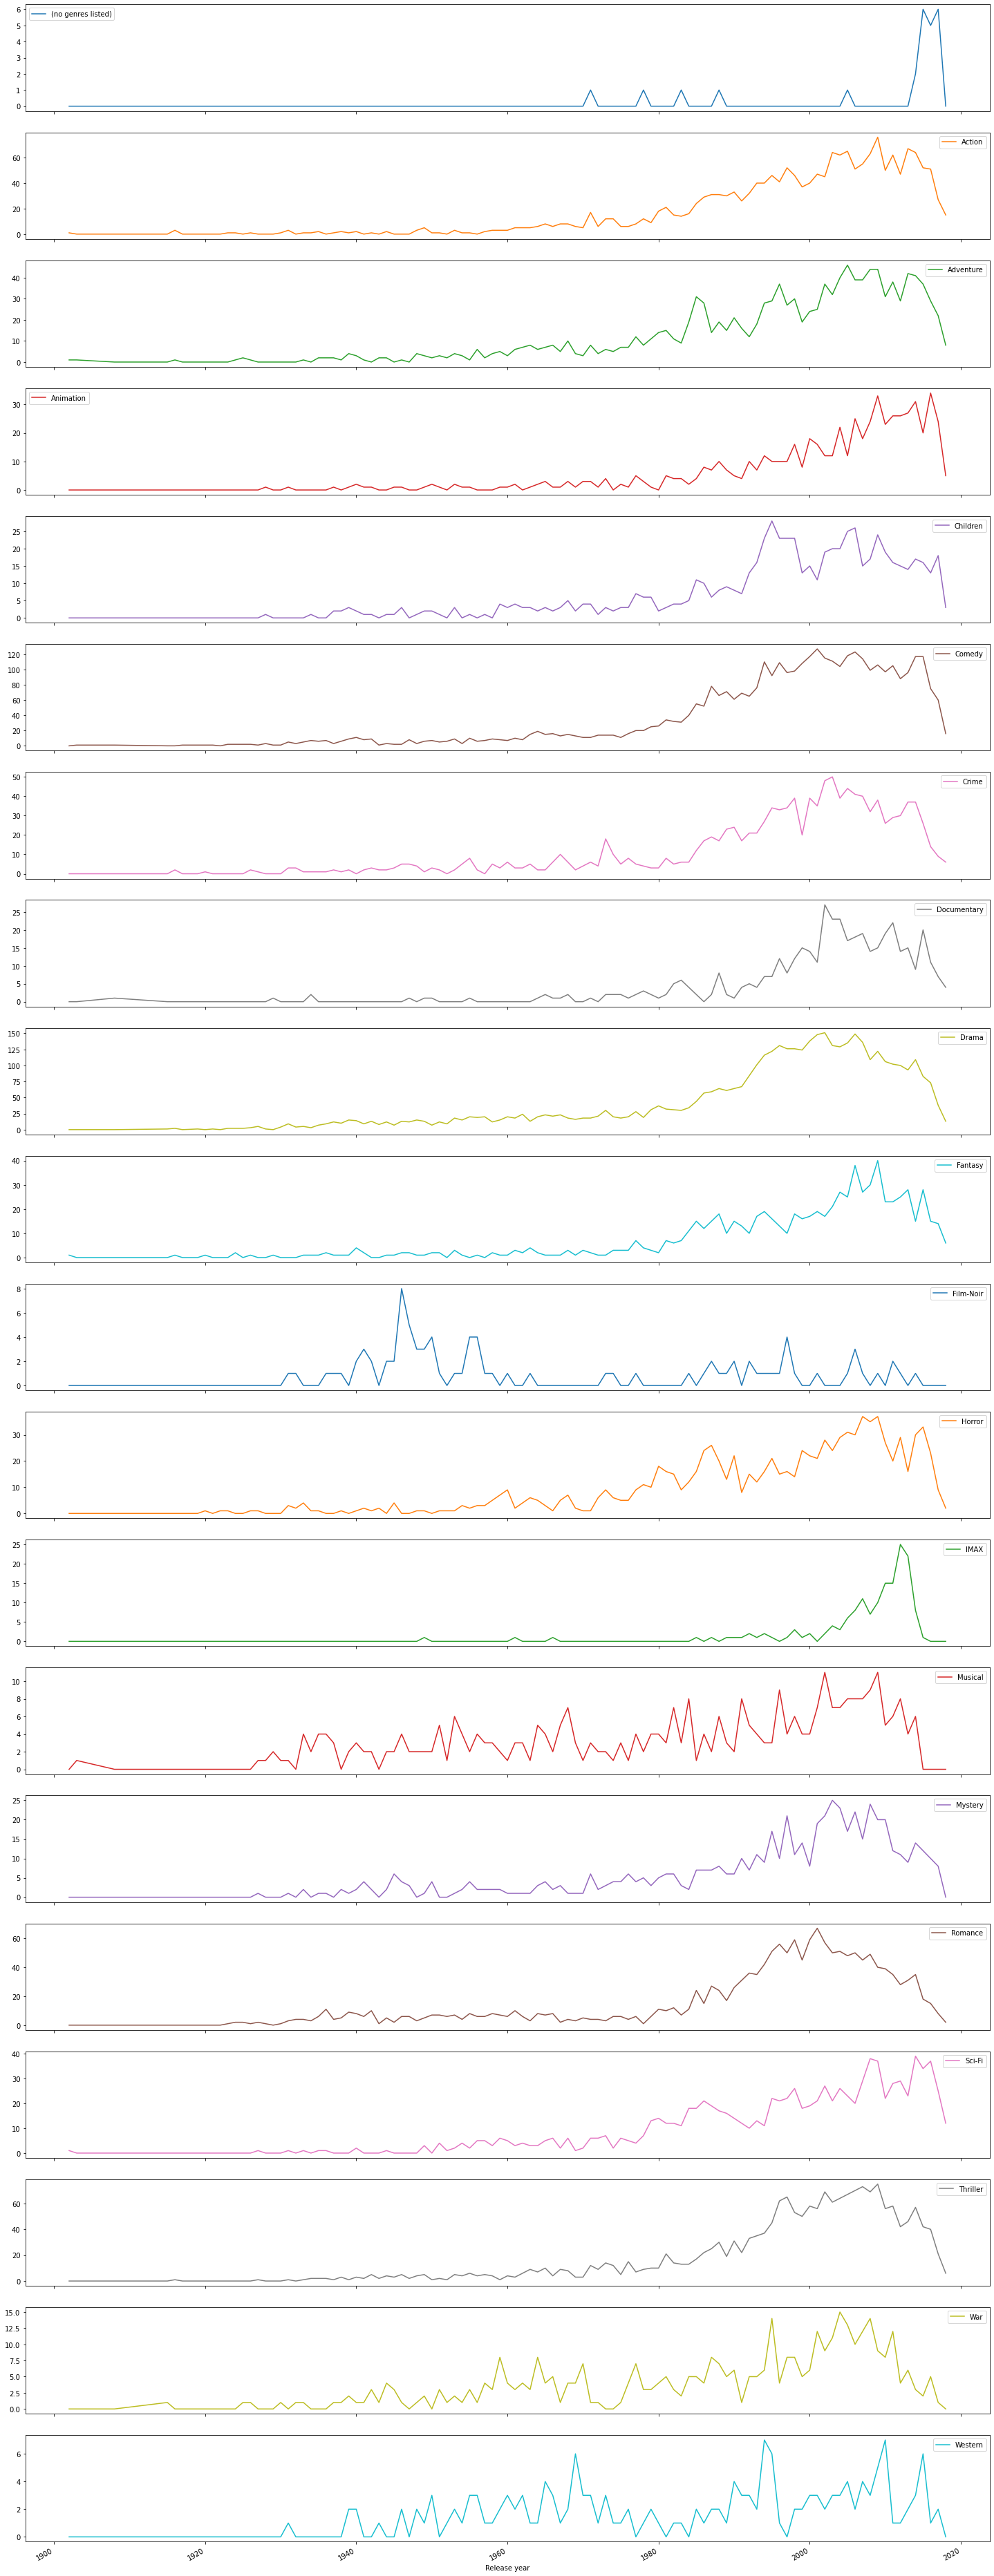

In [56]:
movies = raw_movies.copy()
movies['release_year'] = movies['title'].str.extract('\((\d{4})\)',expand = False)
movies = movies.dropna(axis=0)
movies['release_year'] = movies['release_year'].astype('int64')
movies['genres'] = movies['genres'].str.split('|')
movies_dummies = pd.get_dummies(pd.DataFrame(movies['genres'].tolist()).stack()).sum(level=0)
movies = pd.concat([movies, movies_dummies], axis=1).drop(columns=['genres', 'title', 'movieId'])

movie_year = pd.DataFrame(movies.groupby(movies['release_year']).sum())
movie_year.reset_index(inplace=True)
movie_year.plot(x="release_year", xlabel="Release year", figsize=(25,75), subplots=True);

There are genres that seems to be like evergreens. Some genres loose attraction over time like "Film-Noir" for example. What is also very interesting to observe is that there seems to be a pattern of spikes. Videos in a particular genre are release in one year but drop in the next year and so on. 

## Conclusions
### Can we transform our data to a schema Amazon Personalize is able to process?
Indpendent of the algorithmn we use, the common requirement for the schema is to provide at least
* A userId that reflects the user that triggered a given interaction
* A itemId that identifies the movie
* A timestamp that describes the time of the interaction

All three properties are in place and can be used to build up the datasets for our initial model training. Interactions can furthermore be described by two event types named "rated" or "tagged". If the tagging interaction is a valuable feature, we have to measure and analyse. But those are the options our data analysis revealed. 

Movie metadata like a title, release year or genres can further be used to express item characteristics. 

### Do we have enough data to train a model using Amazon Personalize?
The minimum suggested data volume, Amazon Personalize needs to train a recommendation model is
* More than 50 users.
* More than 50 items.
* More than 1500 interactions.

In [53]:
raw_ratings['userId'].nunique()

610

In [54]:
raw_movies['movieId'].nunique()

9742

In [59]:
len(raw_ratings)

100836

According to our data analysis we have
* 610 unique users
* 9742 movies
* 100836 ratings 

available. All three datasets fullfil the minimun required quota of Amazon Personalize. The interaction dataset can be created out of our rating data and the item dataset out of our movie data. Due to the lack of user metadata we will skip the creation of a dedicated user dataset in the first steps.